# 09 Package Development Demo

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean, Eric Gagliano, Quinn Brencher

## Objectives
The previous modules cover the basics of geospatial data analysis in Python. This module focuses on "putting it all together" to create a scalable geospatial data analysis workflow. This involves moving from a finished Jupyter Notebook that prototypes some specific analysis (e.g., calculating snow-covered area, using a specific area as a test case) to a Python package that can be used by anyone perform this kind of analysis more broadly (e.g., calculates the snow-covered area for a user-defined location and date). This demo provides some guidance on the basics of Python software development for geospatial data analysis applications, specifically moving from statements in a Jupyter Notebook to functions, scripts, modules, and ultimately pip and conda-installable packages. Some of this information may be useful to you as you consider how to organize and document the code you are writing for your final projects. 

In [1]:
import xarray as xr
import rasterio as rio
import rioxarray
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import numpy as np
from shapely.geometry import box
import geopandas as gpd
import sys
import os
import argparse

## 1. Basics of Python code organization
Python code is typically organized according to the following heirarchy: statements, functions and classes, modules, and packages. We are already very familiar with the first two:

- **Statements**: a single instruction, e.g., assigning a variable

In [2]:
dog_age = 2

- **Functions**: a block of code containing multiple statements that executes some specific function

In [3]:
def celebrate_dog_birthday(age):
    print('happy birthday!')
    age += 1
    return age 

The next few we haven't discussed explicitly in this class. 
- **Classes**: a way of bundling data and functionality together

In [2]:
class Dog:
    # Class attribute: these apply to all instances of this class
    species = "Canis familiaris"

    # Instance attributes: these are created when we create an instance of this class
    def __init__(self, name, age):
        self.name = name
        self.age = age

    # Method: this is a function that uses the data associated with a specific instance of our class
    def celebrate_birthday(self):
        print(f'happy birthday {self.name}!')
        self.age += 1
        return

In [3]:
# instantiate an instance of the Dog class
dog1 = Dog(name="Alfonso", age=3)

In [4]:
# variable is defined locally within the class, not globally
species

NameError: name 'species' is not defined

In [5]:
dog1.name

'Alfonso'

In [6]:
dog1.celebrate_birthday()

happy birthday Alfonso!


In [7]:
dog1.age

4

- **Modules**: a Python (`.py`) file containing reusable statements, functions, classes. These statements, functions, and classes can be conveniently imported

In [8]:
# the content of a module dog.py, which contains code related to dogs
!cat dog.py

class Dog:
    species = "Canis familiaris"

    def __init__(self, name, age):
        self.name = name
        self.age = age

    def celebrate_birthday(self):
        print(f'happy birthday {self.name}!')
        self.age += 1
        return

def human_years_to_dog_years(human_years_age):
    if human_years_age < 0:
        raise Exception('Ages must be positive')
    if human_years_age <= 1:
        dog_years_age = human_years_age*15
    elif 1 < human_years_age <= 2:
        dog_years_age = 15 + (human_years_age - 1)*9
    else:
        dog_years_age = 24 + (human_years_age - 2)*5
    return dog_years_age

n_dog_chromosomes = 78

In [9]:
import dog

In [10]:
dog.human_years_to_dog_years(4)

34

In [11]:
dog.n_dog_chromosomes

78

- **Packages**: A group of Python modules organized in a directory. For example the package `pets` contains modules `dog.py`, `cat.py`, and `goldfish.py`. Whether you know it or not, you are very familiar with Python packages--including numpy, pandas, and Xarray! 

In [12]:
!ls -lh pets

total 12K
-rw-rw-r-- 1 jovyan users   31 Mar  2 21:18 cat.py
-rw-rw-r-- 1 jovyan users  642 Mar  2 21:15 dog.py
-rw-rw-r-- 1 jovyan users    0 Mar  2 21:15 goldfish.py
-rw-rw-r-- 1 jovyan users    0 Mar  2 21:15 __init__.py
drwxrwsr-x 2 jovyan users 4.0K Mar  3 18:01 __pycache__


In [13]:
from pets import cat

In [14]:
cat.meow()

meowww


### 1.1 Motivation for software development
Though it may sound intimidating, by this point in the course, you have all the skills you need to do develop Python software for geospatial data analysis applications. This will involve moving code from Jupyter Notebooks to Python modules and potentially creating Python packages. 

*But why would we move beyond Jupyter Notebooks?*

Jupyter Notebooks are an excellent tool for developing a geospatial data analysis workflow, for example, writing code to calculate an area-inundation curve for islands (Lab 06). Within a Jupyter Notebook, we often develop our approach based on a single or handful of test cases, e.g., a single island in Washington. But often in our research, we want to scale our analysis. Perhaps we want to create area-inundation curves for thousands of islands across Earth. In this case, it would not be efficient to create thousands of Jupyter Notebooks and run them manually. Instead, we want to make a reusable collection of code to perform our analysis that we can run thousands of times with ease. This code can be easily stored in Python modules. Key point: 

- **Python modules allow us to efficiently reuse our code and scale our geospatial data analysis workflows**

Alternatively, perhaps we have developed a complicated but brilliant analysis workflow that we want other people to be able to easily implement as well. Let's say this workflow calculates the cost of flood damage based on remote sensing data. Rather than muddling their way through a gigantic Jupyter Notebook with hundreds of cells, we want users of various experience levels to simply provide the date and locations of the flood and get our estimate for the cost of the damage. In this case, we can create a well-documented Python package that it is simple for users to install and use on their own. Key point:

- **Python packages allow other people to easily implement our geospatial analysis workflows for their own use cases**

### 1.2 Creating effective functions
In many cases, functions are the unit of code that we interact with most frequently. When looking at someone else's software, we are often trying to understand it on the function level. When developing more complicated software, carefully designed functions are essential to make our code efficient, robust to errors, and easily understandable to users (including yourself after a two-week break). Quick functions in Jupyter Notebooks during development can be sloppy, but functions that are finished and ready to go into a module should not be, lest problems arise. Here, let's start with a terrible function and make it better. 

In [15]:
# load in Washington COP90 DEM dataset
dem_fn = '../../../../gda_demo_data/dem_data/WA_COP90_utm_gdalwarp_lzw.tif'
dem_da = rioxarray.open_rasterio(dem_fn).squeeze()
dem_da = dem_da.where(dem_da != 0)

In [18]:
# a terrible function
def Noise(d, t=3.0, ft=3):
    f_z = ndimage.median_filter(d, size=ft, mode="nearest")
    dev = d - f_z
    std = np.nanstd(dev)
    Noise_var = np.abs(dev) > (t * std)
    elevation = d.where(~Noise_var)
    return elevation

In [19]:
filtered_dem_da = Noise(dem_da)

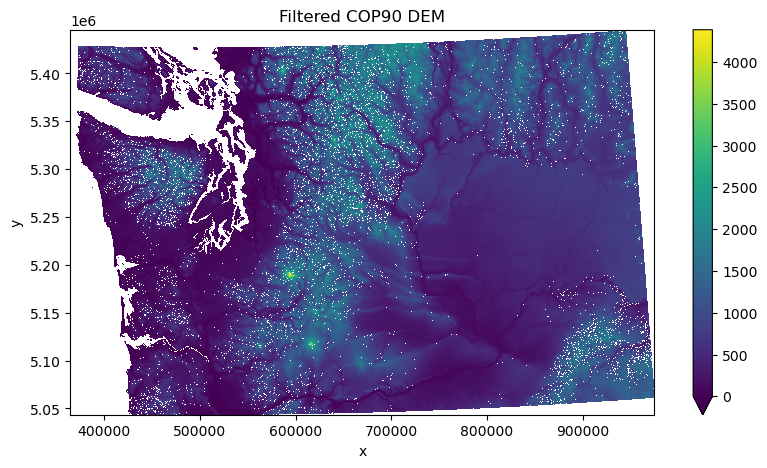

In [20]:
f, ax = plt.subplots(figsize=(10, 5))
filtered_dem_da.plot.imshow(ax=ax, cmap='viridis', vmin=0)
ax.set_title('Filtered COP90 DEM')
ax.set_aspect('equal')

#### 1.2.1 Style
Using good style makes functions easy to understand and use, for ourselves and others. Some tips:

- Use descriptive but short names (it's ok to take a second to think about what the right name is for something)
- Use [snakecase](https://en.wikipedia.org/wiki/Snake_case) for function names
- Name things with code reuse in mind
- Use comments--doesn't have to be every line, but as needed

In [21]:
def remove_outliers(array, std_dev_threshold=3.0, filter_size=3):
    # smooth array with median filter
    filtered = ndimage.median_filter(array, size=filter_size, mode="nearest")
    residuals = array - filtered
    std_dev = np.nanstd(residuals)
    # classify locations with residuals larger than threshold
    outliers = np.abs(residuals) > (std_dev_threshold * std_dev)
    # return array with outliers set to nan
    return array.where(~outliers)

#### 1.2.2 Docstrings
Our function is clearer now that we've improved the naming, but we're still missing some essential context about what it does overall and how to use it. This is typically accomplished using docstrings, multiline strings at the beginning of a function or class that contain a short description of the function and details on the parameters and what they return. Hint--AI is pretty good at writing these, and this is a great use case for it. 

In [17]:
def remove_outliers(array, std_dev_threshold=3.0, filter_size=3):
    """
    Remove outliers from an Xarray DataArray by applying a median filter.
    
    Parameters:
        array (xr.DataArray): Input DataArray with dimensions (x, y).
        std_dev_threshold (float): Number of standard deviations to use for outlier detection.
        filter_size (int): Size of the median filter kernel (default: 3x3).
    
    Returns:
        xr.DataArray: DataArray with outliers removed (set to NaN).
    """
    # smooth array with median filter
    filtered = ndimage.median_filter(array, size=filter_size, mode="nearest")
    residuals = array - filtered
    std_dev = np.nanstd(residuals)
    # classify locations with residuals larger than threshold
    outliers = np.abs(residuals) > (std_dev_threshold*std_dev)
    # return array with outliers set to nan
    return array.where(~outliers)

#### 1.2.3 Raising Exceptions
Users (including you) will make mistakes that cause your functions to fail. In some cases, this will naturally cause your function to raise a warning or exception. In some cases, your functions will fail silently, and the user will have no idea what went wrong or where, leading them on a long and frustrating debugging journey. When writing a function, it's good to think about under what conditions your function will fail silently, and to raise an exception so that this doesn't happen. 

In [18]:
# What happens if we use a filter_size of 1?  
filtered_dem_da = remove_outliers(dem_da, filter_size=1)

In [19]:
# The array values are not changed! 
(filtered_dem_da - dem_da).sum()

<xarray.DataArray ()> Size: 4B
array(0., dtype=float32)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [20]:
# raising an exception for filter size of 1 or less
def remove_outliers(array, std_dev_threshold=3.0, filter_size=3):
    """
    Remove outliers from an Xarray DataArray by applying a median filter.
    
    Parameters:
        array (xr.DataArray): Input DataArray with dimensions (x, y).
        std_dev_threshold (float): Number of standard deviations to use for outlier detection.
        filter_size (int): Size of the median filter kernel (default: 3x3).
    
    Returns:
        xr.DataArray: DataArray with outliers removed (set to NaN).
    """
    if filter_size <= 1:
        raise ValueError('filter size must greater than 1')
    # smooth array with median filter
    filtered = ndimage.median_filter(array, size=filter_size, mode="nearest")
    residuals = array - filtered
    std_dev = np.nanstd(residuals)
    # classify locations with residuals larger than threshold
    outliers = np.abs(residuals) > (std_dev_threshold*std_dev)
    # return array with outliers set to nan
    return array.where(~outliers)

In [21]:
filtered_dem_da = remove_outliers(dem_da, filter_size=1)

ValueError: filter size must greater than 1

#### 1.2.4 Type hints
Type hints are annotations that specify the expected data types of function arguments and return values. They make code more readable and help IDEs, debuggers, and tests to identify problems with your code--e.g., you've made a modification that accidentally changed the type of a function output.

For example, let's simulate a mistake by modifying our function to output a numpy array rather than a DataArray. 

In [22]:
def remove_outliers(array, std_dev_threshold=3.0, filter_size=3):
    """
    Remove outliers from an Xarray DataArray by applying a median filter.
    
    Parameters:
        array (xr.DataArray): Input DataArray with dimensions (x, y).
        std_dev_threshold (float): Number of standard deviations to use for outlier detection.
        filter_size (int): Size of the median filter kernel (default: 3x3).
    
    Returns:
        xr.DataArray: DataArray with outliers removed (set to NaN).
    """
    if filter_size <= 1:
        raise ValueError('filter size must greater than 1')
    # smooth array with median filter
    filtered = ndimage.median_filter(array, size=filter_size, mode="nearest")
    residuals = array - filtered
    std_dev = np.nanstd(residuals)
    # classify locations with residuals larger than threshold
    outliers = np.abs(residuals) > (std_dev_threshold*std_dev)
    # return array with outliers set to nan
    return array.where(~outliers).values #<-------------- MISTAKE HERE ---------------------

Now let's add type hints and see what happens. 

In [23]:
def remove_outliers(array: xr.DataArray, std_dev_threshold: float = 3.0, filter_size: int = 3) -> xr.DataArray:
    """
    Remove outliers from an Xarray DataArray by applying a median filter.
    
    Parameters:
        array (xr.DataArray): Input DataArray with dimensions (x, y).
        std_dev_threshold (float): Number of standard deviations to use for outlier detection.
        filter_size (int): Size of the median filter kernel (default: 3x3).
    
    Returns:
        xr.DataArray: DataArray with outliers removed (set to NaN).
    """
    if filter_size <= 1:
        raise ValueError('filter size must greater than 1')
    # smooth array with median filter
    filtered = ndimage.median_filter(array, size=filter_size, mode="nearest")
    residuals = array - filtered
    std_dev = np.nanstd(residuals)
    # classify locations with residuals larger than threshold
    outliers = np.abs(residuals) > (std_dev_threshold*std_dev)
    # return array with outliers set to nan
    return array.where(~outliers).values #<-------------- MISTAKE HERE ---------------------

In [24]:
filtered_dem_da = remove_outliers(dem_da, filter_size=2)

In [25]:
type(filtered_dem_da)

numpy.ndarray

Nothing happens! Python doesn't enforce type hints when code is run. However, there are [packages](https://mypy-lang.org/) and IDEs (e.g. VSCode) that will catch these inconsistencies. 

At this point, our function is polished and ready to be inserted into a module! 

### 1.3 Classes
Broadly, the same best practices described above for functions also apply to classes. Classes should ideally also get useful variable names, get comments, get docstrings, raise exceptions where appropriate, and use type hints. 

When should you use a class instead of a function? 

- When you want to store a variable across multiple function calls.
- When you want to group related functions

For example, let's use our `dem_da` DataArray. Let's imagine we want to do a series of processing tasks on our DataArray: 
1) Crop the dataset to an area of interest
2) Reproject the cropped area
3) Find the value of the center pixel
4) Find the mean, min, and max values in the dataset.

All of these tasks rely on the same three inputs: an Xarray DataArray, a bounding box, and an EPSG code. In reality we probably wouldn't create functions for all of these one-liners, but for this example it's ok. Here's what it might look like to do all of this with functions:

In [31]:
# functions to accomplish the processing tasks outlined above
def create_aoi(aoi_bounds, aoi_crs):
    aoi = box(aoi_bounds["minx"], aoi_bounds["miny"], aoi_bounds["maxx"], aoi_bounds["maxy"])
    return gpd.GeoDataFrame(geometry=[aoi], crs=aoi_crs)

def reproject_aoi(aoi_gdf, target_crs):
    return aoi_gdf.to_crs(target_crs)

def crop_to_aoi(elevation, aoi_gdf):
    return elevation.rio.clip(aoi_gdf.geometry, aoi_gdf.crs, all_touched=True)

def reproject_elevation(elevation, target_crs):
    return elevation.rio.reproject(target_crs)

def get_center_pixel_value(elevation):
    center_x = elevation.x.mean().item()
    center_y = elevation.y.mean().item()
    return elevation.sel(x=center_x, y=center_y, method="nearest").values.item()

def get_summary_stats(elevation):
    return {
        "min": elevation.min().item(),
        "max": elevation.max().item(),
        "mean": elevation.mean().item(),
    }

In [26]:
# setting up parameters 
aoi1_bounds = {"minx": -122.3, "miny": 46.1, "maxx": -122.0, "maxy": 46.3} # Mt. St. Helens
target_crs = 'EPSG:2927' # Washington state plane (south)
aoi_crs = 'EPSG:4326'

In [33]:
# performing the tasks outlined above

# 1. Cropping the dem to the bounds
aoi_gdf = create_aoi(aoi1_bounds, aoi_crs)
aoi_gdf_proj = reproject_aoi(aoi_gdf, dem_da.rio.crs)
cropped_elevation = crop_to_aoi(dem_da, aoi_gdf_proj)

# 2. Reprojecting the cropped DEM
reprojected_elevation = reproject_elevation(cropped_elevation, target_crs)

# 3. Finding the center pixel value
center_value = get_center_pixel_value(reprojected_elevation)
print(f"elevation at center pixel: {center_value}")

# 4. Computing some statistics
stats = get_summary_stats(reprojected_elevation)
print(f"elevation stats - Min: {stats['min']}, Max: {stats['max']}, Mean: {stats['mean']}")

elevation at center pixel: 1480.8846435546875
elevation stats - Min: 357.41864013671875, Max: 2513.9326171875, Mean: 1005.2244262695312


Notice how we're creating all of these intermediate variables, which we then have to pass to the next function. There's no organized way that we're keeping track of them, other than their names. Now let's see what it would look like to use a class to do the same analysis. 

In [27]:
class DEMProcessor:
    def __init__(self, dem: xr.DataArray, aoi_bounds: dict, target_crs: str):
        """
        Contains functions to process DEM data.

        Parameters:
            dem (xr.DataArray): Elevation data with dimensions (y, x).
            aoi_bounds (dict): Bounding box in lat/lon (EPSG:4326).
            target_crs (str): Target CRS (e.g., "EPSG:2285").
        """
        self.dem = dem
        self.target_crs = target_crs

        # create a shapely box for aoi
        self.aoi = box(aoi_bounds["minx"], aoi_bounds["miny"], aoi_bounds["maxx"], aoi_bounds["maxy"])
        self.aoi_crs = "EPSG:4326"  # Assume aoi is initially in WGS84

    def convert_aoi_to_projected(self):
        aoi_gdf = gpd.GeoDataFrame(geometry=[self.aoi], crs=self.aoi_crs)
        aoi_gdf = aoi_gdf.to_crs(self.dem.rio.crs)

        # update the aoi with the projected geometry
        self.aoi = aoi_gdf.geometry.iloc[0]
        self.aoi_crs = self.dem.rio.crs
        return self

    def crop_to_aoi(self):
        self.dem = self.dem.rio.clip([self.aoi], self.aoi_crs)
        return self  

    def reproject(self):
        self.dem = self.dem.rio.reproject(self.target_crs)
        return

    def get_center_pixel_value(self):
        center_x = self.dem.x.mean().item()
        center_y = self.dem.y.mean().item()
        self.center_value = self.dem.sel(x=center_x, y=center_y, method="nearest").values.item()
        return self.center_value

    def get_summary_stats(self):
        self.summary_stats = {
            "min": self.dem.min().item(),
            "max": self.dem.max().item(),
            "mean": self.dem.mean().item()}
        return self.summary_stats

In [29]:
# instantiate our class
aoi1_processor = DEMProcessor(dem_da, aoi1_bounds, target_crs)
# run all of our preprocessing functions
aoi1_processor.convert_aoi_to_projected().crop_to_aoi().reproject()

center_pixel = aoi1_processor.get_center_pixel_value()
print(f"elevation at center pixel: {center_pixel}")
stats = aoi1_processor.get_summary_stats()
print(f"elevation stats - Min: {stats['min']}, Max: {stats['max']}, Mean: {stats['mean']}")

elevation at center pixel: 1479.970703125
elevation stats - Min: 357.41864013671875, Max: 2513.9326171875, Mean: 1005.5317993164062


In this case we don't have to pass a long list of intermediate variables between our functions. They're preserved as attributes in our class. Whenever we want to reference them, we can just access them from our class. Why might this look familiar? Because many of the objects that we interact with in Python are classes--this includes lists, dictionaries, pandas DataFrames, etc.

### 1.4 Python modules 
As discussed above, a module is simply a `.py` file that contains Python code. A single module typically contains code that is related. Creating a Python module is a simple as creating a `.py` file and copying and pasting code into it. Frequently we use this code by importing from the module (into something like a Jupyter Notebook, or into another module). If your module is in your current working directory, you can simply do the following:

In [30]:
import dog

If your module is not in your current working directory, you can tell Python where to look for it. Python looks for modules in the directories listed in `sys.path`. You can add a the directory containing your module to `sys.path`. 

In [31]:
# these are the directories where Python looks for modules to import
sys.path

['/home/jovyan/GDA_Wi25_jupyterbook/book/modules/09_Advanced_workflows',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/home/jovyan/.local/lib/python3.11/site-packages',
 '/opt/conda/lib/python3.11/site-packages']

In [32]:
# this is a module in our "pets" package from earlier
import cat

ModuleNotFoundError: No module named 'cat'

In [33]:
# adding the path to our pets package, where the cat module is stored
sys.path.append("/home/jovyan/GDA_Wi25_jupyterbook/book/modules/09_Advanced_workflows/pets")

In [34]:
import cat

Jupyter caches imported modules. If you're working on a module that you've imported in a Jupyter Notebook, and you want your imported module to reflect those changes without restarting the kernel, you can use:

In [41]:
%load_ext autoreload
%autoreload 2

### 1.5 Python scripts

A Python script is a type of Python module (a `.py` file containing Python code) that can be executed directly to perform some task. Scripts are an efficient way of running an entire workflow from front to back without the excess hassle of a Jupyter Notebook (or a series of Jupyter Notebooks). 

Python assigns a special variable called `__name__` to every Python module. When a module is imported, `__name__` corresponds to the name of the file (e.g. `"dog"` above). But when a module is run directly, it is assigned the name `"__main__"`. Thus, when we want code in a Python module to be executed when it is run, we precede that code with: `if __name__ == "__main__":`

Often, scripts will contain a function called `main()` to be executed when a module is run directly. 

In [35]:
def main():
    print("I'm being run directly!")

if __name__ == "__main__":
    main()

I'm being run directly!


In a Jupyter Notebook, `__name__ == "__main__"` because Python treats each cell being executed as part of the main execution environment rather that a module being imported. 

To run a Python script directly from the command line, you can simply do: `python my_script.py` if you're in the same directory, or `python path/to/my_script.py` if not. To make a script executable on the command line without explicitly calling `python`, add a "shebang" at the top, e.g.:

In [43]:
#!/usr/bin/env python3

This tells the operating system to use `python3` to execute the script. 

#### 1.5.1 Arguments
Frequently, we need to provide arguments to the scripts that we will run on the command line (in the same way that we need to provide arguments to functions). We have experience doing this with `gdalwarp`, for example. Inside the script, we need to set up a way to parse these arguments, make sure they're the correct type, and provide them to the code we're going to run. There is more than one library that does this, but for now, we'll use Python's [`argparse` module](https://docs.python.org/3/library/argparse.html). 

In [36]:
# create a main function so that we can run our DEM outlier removal function in a script
def main():
    # set up argument parsing
    parser = argparse.ArgumentParser(description="Remove outliers from a DEM using a median filter.")
    
    parser.add_argument("dem_path", type=str, help="Path to the DEM file (GeoTIFF).")
    parser.add_argument("std_dev_threshold", type=float, help="Standard deviation threshold for outlier detection.")
    parser.add_argument("filter_size", type=int, help="Size of the median filter kernel.")

    args = parser.parse_args()

    # Load dem into xarray DataArray
    dem_da = rioxarray.open_rasterio(args.dem_path).squeeze()
    dem_da = dem_da.where(dem_da != 0)

    # perform outlier removal
    filtered_dem_da = remove_outliers(dem_da, args.std_dev_threshold, args.filter_size)

    # save output
    base, ext = os.path.splitext(dem_path)
    output_path = f"{base}_filtered{ext}"
    filtered_dem_da.rio.to_raster(output_path)
    print(f"Processed DEM saved to {output_path}")

Excellent. Now let's look at our completed script (which I prepared beforehand):

In [37]:
!cat dem_filtering.py

#!/usr/bin/env python3

import argparse
import xarray as xr
import rasterio as rio
import rioxarray 
import numpy as np
from scipy import ndimage
import os

def remove_outliers(array: xr.DataArray, std_dev_threshold: float = 3.0, filter_size: int = 3) -> xr.DataArray:
    """
    Remove outliers from an Xarray DataArray by applying a median filter.
    
    Parameters:
        array (xr.DataArray): Input DataArray with dimensions (x, y).
        std_dev_threshold (float): Number of standard deviations to use for outlier detection.
        filter_size (int): Size of the median filter kernel (default: 3x3).
    
    Returns:
        xr.DataArray: DataArray with outliers removed (set to NaN).
    """
    if filter_size <= 1:
        raise ValueError('filter size must greater than 1')
    # smooth array with median filter
    filtered = ndimage.median_filter(array, size=filter_size, mode="nearest")
    residuals = array - filtered
    std_dev = np.nanstd(residuals)
    # classify locations

Now let's give our script execution permissions. 

In [46]:
!chmod +x dem_filtering.py

Now let's try running our script on one of our example DEMs. Unfortunately I've forgotten what my arguments were supposed to be! Luckily we added those `help` strings when setting our arguments up. 

In [38]:
!./dem_filtering.py -h

usage: dem_filtering.py [-h] dem_path std_dev_threshold filter_size

Remove outliers from a DEM using a median filter.

positional arguments:
  dem_path           Path to the DEM file (GeoTIFF).
  std_dev_threshold  Standard deviation threshold for outlier detection.
  filter_size        Size of the median filter kernel.

options:
  -h, --help         show this help message and exit


In [39]:
# we defined this above
dem_fn

'../../../../gda_demo_data/dem_data/WA_COP90_utm_gdalwarp_lzw.tif'

In [40]:
!./dem_filtering.py $dem_fn 3.0 3

Processed DEM saved to ../../../../gda_demo_data/dem_data/WA_COP90_utm_gdalwarp_lzw_filtered.tif


#### 1.5.2 Outputs 
When executing cells in a jupyter notebook, we have the option to interact with all of the objects we define. When running a script, this is not the case. Scripts typically have a couple of distinct kinds of output:

- Console ouput: this is text or images printed straight to the terminal. `print()` statements inside a script will result in text printed to the terminal. Some scripts perform more complicated logging, which can be dynamically output to the terminal as the script runs.
- Files: scripts frequently write files (be they `.tif`, `.png`, `.csv`, `.geojson`, etc) to the disk.

Because we don't get to interact with every object in our scripts, we need to plan ahead about what our scripts will output, and how we will use those outputs for analysis down the line. We need to think about things like consistent and clear filenames, disk space, directory organization, etc. 

### 1.6 Python packages
As discussed above, a Python package is simply a bunch of Python modules (`.py` files containing Python code) in a directory. That said, there is a particular structure that is required for Python to interpret a directory as a Python package. 

A Python package usually contains a file called `__init__.py` (this was required before Python 3.3 and it's still best practice to include it for backwards compatibility). This file tells Python that this directory is a package. The `__init__.py` file can be empty. Or can alternatively contain some details about the package, import some of the modules, or perform other setup tasks. Here's an example of what's in the `__init__.py` file for Eric's `easysnowdata` package:
```
"""Top-level package for easysnowdata."""

__author__ = """Eric Gagliano"""
__email__ = "egagli@uw.edu"
__version__ = "0.0.18"
__all__=['easysnowdata','utils','remote_sensing','automatic_weather_stations','topography','hydroclimatology']

import easysnowdata.easysnowdata
import easysnowdata.utils
import easysnowdata.remote_sensing
import easysnowdata.automatic_weather_stations
import easysnowdata.topography
import easysnowdata.hydroclimatology
```

In our `pets` package, the `__init__.py` file is empty. We are still able to import the package locally. 

In [50]:
!ls -lh pets

total 12K
-rw-rw-r-- 1 jovyan users   31 Mar  2 21:18 cat.py
-rw-rw-r-- 1 jovyan users  642 Mar  2 21:15 dog.py
-rw-rw-r-- 1 jovyan users    0 Mar  2 21:15 goldfish.py
-rw-rw-r-- 1 jovyan users    0 Mar  2 21:15 __init__.py
drwxrwsr-x 2 jovyan users 4.0K Mar  3 18:01 __pycache__


Note that Python automatically generates the `__pycache__` file on import. This file stores your compiled Python code so it doesn't need to be recompiled next time it's run. Packages can additionally have subpackages--that is, additional directories within the main directory that contain additional modules. This is primarily for organizational purposes. Each subpackage must also contain an `__init__.py` file. 

#### 1.6.1 Notes on package structure
Technically, a Python package is a directory containing Python modules. But when packages are ready to be distributed, they typically have an outer directory an outer directory (the "project root") which contains all of the files required for package distribution. This includes, for example, the package `README.md` file, which tells people how to use the package. The outer directory and the actual package directory typically have the same name.

### 1.7 Making packages installable

Previously, we installed a package by adding the directory it is in to our `sys.path` list. This is fine, but it only lasts until we restart Python. Sometimes we want a package to be installed into our actual Python environment, such that when the environment is activated, our package will be importable. To do this, we can use [pip](pypi.org/project/pip/), the package installer for Python. We need a special file called `pyproject.toml` that tells pip how our package should be built and installed, as well as some basic information about it. Here's an example of a barebones `pyproject.toml` file for our `pets` package. Note that a `pyproject.toml` file will often include more information than this: https://packaging.python.org/en/latest/guides/writing-pyproject-toml/. 

In [51]:
!cat pyproject.toml

[build-system]
requires = ["setuptools"]
build-backend = "setuptools.build_meta"

[project]
name = "pets"
version = "0.1.0"
description = "A simple Python package"
authors = [{ name = "Quinn Brencher", email = "gbrench@uw.edu" }]
dependencies = []  # Add required packages here

This is all that's needed to install the package in the current environment. The `-e` flag installs the package in editable mode, which means that changes we make to the package will be reflected when we reimport the package (or when we have run `%autoreload 2`)

In [52]:
# Let's not actually run this, we don't need this package
# !pip install -e /path/to/pets

If your package is hosted on Github as a public repository, this is all that's needed for anyone to install your package. In fact, they can install it locally without even needing to clone it first by providing a Github link:

In [53]:
# We already have this package installed 
# !pip install git+https://github.com/egagli/easysnowdata.git

At a certain point in a Python project, when you're ready for your package to be distributed and used widely, it may make sense to make your package pip and conda installable without a github link. This is beyond the scope of this demo. Please see the following if you'd like to explore further:

- [Contributing a package to conda-forge](https://conda-forge.org/docs/maintainer/adding_pkgs/#creating-recipes)
- [Uploading a package to the Python Package Index](https://packaging.python.org/en/latest/tutorials/packaging-projects/)

### 1.8 Other features of Python packages

If you look in a package like `easysnowdata`, you'll see some other files and directories in the root directory that aren't the package directory. The following is a brief overview of what some of these files are. 

#### 1.8.1 `README.md`
You already have some experience preparing a `README.md` file for your project repo! This is the first thing a user will see when they visit your repository. It usually provides on what your package does, how to install it, some example usage, a citation, and guidelines for contributing to your package. You may find that your package needs more documentation than a simple `README.md` file. In this case, you can set up some additional documentation which could live in a `docs` directory. There are various tools (e.g. [MkDocs](https://www.mkdocs.org/getting-started/)) to help you build nice documentation for your package. Github will even host a website for your docs (e.g. [easysnowdata](egagli.github.io/easysnowdata/))

#### 1.8.2 `.gitignore`
This file tells Git which files to ignore when committing to Github. This could include a large dataset that you don't want to accidentally try to push, as well as temporary files, logs, dependencies, configuration files etc. Typically one begins with a template `.gitignore` file and adjusts it to their needs. Here's an example template:

```
# Byte-compiled / optimized / DLL files
__pycache__/
*.py[cod]
*$py.class

# C extensions
*.so

# Distribution / packaging
.Python
build/
develop-eggs/
dist/
downloads/
eggs/
.eggs/
lib/
lib64/
parts/
sdist/
var/
wheels/
*.egg-info/
.installed.cfg
*.egg
MANIFEST

# PyInstaller
#  Usually these files are written by a python script from a template
#  before PyInstaller builds the exe, so as to inject date/other infos into it.
*.manifest
*.spec

# Installer logs
pip-log.txt
pip-delete-this-directory.txt

# Unit test / coverage reports
htmlcov/
.tox/
.coverage
.coverage.*
.cache
nosetests.xml
coverage.xml
*.cover
.hypothesis/
.pytest_cache/

# Translations
*.mo
*.pot

# Django stuff:
*.log
local_settings.py
db.sqlite3

# Flask stuff:
instance/
.webassets-cache

# Scrapy stuff:
.scrapy

# Sphinx documentation
docs/_build/

# PyBuilder
target/

# Jupyter Notebook
.ipynb_checkpoints

# pyenv
.python-version

# celery beat schedule file
celerybeat-schedule

# SageMath parsed files
*.sage.py

# Environments
.env
.venv
env/
venv/
ENV/
env.bak/
venv.bak/

# Spyder project settings
.spyderproject
.spyproject

# Rope project settings
.ropeproject

# mkdocs documentation
/site

# mypy
.mypy_cache/

# Data files
*.h5
*.hdf
*.hdf5
*.nc
*.tif
```

#### 1.8.3 `environment.yml`
An `environment.yml` file describes which other packages your package depends on. Any package that needs to be imported to run the code in your package is a dependency. This type of file allows you to create a conda environment that will your package can run in. There will be more on this in the next module. 

#### 1.8.4 `LICENSE`
This file describes the legal permissions and restrictions for using, modifying, and distributing the code in your package. There are many template licences that may fit your needs. The MIT license is a permissive license commonly used for open-source software that can be used, modified, and distributed without restrictions. Here a template for the MIT license:

```
Copyright (c) <year> <copyright holders>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
```

#### 1.8.5 `notebooks/`
Jupyter Notebooks typically live in their own director in the root package directory. 

These are the basic things one expects to see in a package, but others may be appropriate as well! You could have a tutorial notebook you could have a data directory, you could have a directory containing relevant image outputs, and you could have other files related to package distribution, environment management, etc. It depends on what you need to do, and it's up to you! 

### 1.9 Testing

Ideally, Python packages will have tests that make sure that individual functions and components of your package are working as intended. These tests frequently live in their own directory `tests` inside the package root directory and contains names corresponding to the modules they contain tests for. For example, a test module for the module `dog.py` in the `pets` package might have the name `test_dog.py`. Tests will frequently try your functions and classes out using dummy or example data that should product an expected output. If this output is not produced, the test is failed. This can help identify bugs introduced during the course of coding. Tests can be run manually upon making changes to your package, or automatically upon committing new code using tools like [Github Actions](https://github.com/features/actions). 

Writing tests can be tedious, but luckily this is something that AI does pretty well--simply provide a function and ask it to create some tests for the function. As with any AI code, double-check to make sure it's correct. Let's imagine a test for our `remove_outliers()` function. 

In [54]:
def test_remove_outliers():
    # Create a simple 5x5 test array with an outlier
    data = np.array([
        [1, 2, 2, 2, 1],
        [2, 1000, 2, 2, 2],  # 1000 is an outlier
        [2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2],
        [1, 2, 2, 2, 1]
    ])
    
    da = xr.DataArray(data)

    # Run the function to detect the outlier
    filtered_da = remove_outliers(da, std_dev_threshold=2, filter_size=3)

    # Check if the outlier was set to NaN
    assert np.isnan(filtered_da[1, 1]), "Outlier was not removed"

    # Ensure non-outliers remain unchanged
    assert filtered_da[0, 0] == 1, "Unexpected value change"

    return filtered_da # for demonstration purposes, we'll return the filtered dataaaray here

In [55]:
filtered_da = test_remove_outliers()

In [56]:
# we passed the test! 
filtered_da

array([[ 1.,  2.,  2.,  2.,  1.],
       [ 2., nan,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.],
       [ 1.,  2.,  2.,  2.,  1.]])

Now let's take a look at the contents of a module that contains this test. 

In [57]:
!cat test_dem_filtering.py

import pytest
import numpy as np
import xarray as xr
from dem_filtering import remove_outliers

def test_remove_outliers():
    # Create a simple 5x5 test array with an outlier
    data = np.array([
        [1, 2, 2, 2, 1],
        [2, 1000, 2, 2, 2],  # 1000 is an outlier
        [2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2],
        [1, 2, 2, 2, 1]
    ])
    
    da = xr.DataArray(data)

    # Run the function to detect the outlier
    filtered_da = remove_outliers(da, std_dev_threshold=2, filter_size=3)

    # Check if the outlier was set to NaN
    assert np.isnan(filtered_da[1, 1]), "Outlier was not removed"

    # Ensure non-outliers remain unchanged
    assert filtered_da[0, 0] == 1, "Unexpected value change"

In [58]:
# let's run our test manually
!pytest test_dem_filtering.py

============================= test session starts ==============================
platform linux -- Python 3.11.6, pytest-8.0.2, pluggy-1.3.0
rootdir: /home/jovyan/GDA_Wi25_jupyterbook/book/modules/09_Advanced_workflows
plugins: anyio-4.0.0
collected 1 item                                                               

test_dem_filtering.py .                                                  [100%]

============================== 1 passed in 1.61s ===============================


### Now you're ready to go forth and develop Python packages! There is more to learn, but if you know the basics, you can pick it up as you go along. 